# Basic NLP on Disaster Tweets

This is a getting started competition of predicting whether a tweet is actually referring to real disasters.

### Competition Description
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies.

Well, Thanks to Holf Yuen for creating this amazing notebook.


Before going ahead to we should follow through the very basic things which are actively related with any machine learning problem along with this one too.
F1 is calculated as follows:



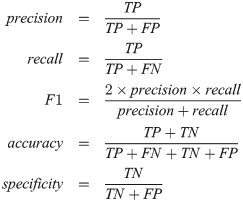


True Positive [TP] = your prediction is 1, and the ground truth is also 1 - you predicted a positive and that's true!

False Positive [FP] = your prediction is 1, and the ground truth is 0 - you predicted a positive, and that's false.

False Negative [FN] = your prediction is 0, and the ground truth is 1 - you predicted a negative, and that's false.

Contents: in this notebook which will be coverd .

* <a href='#basic'>Basic exploration</a>
* <a href='#keyword'>Keywords</a>
* <a href='#location'>Locations</a>
* <a href='#text'>Clean up text</a>
* <a href='#stat'>Text statistics</a>
* <a href='#gram'>Unigrams and bigrams</a>
* <a href='#encode'>Encoding and Vectorizers</a>
* <a href='#simple'>Simple model</a>
* <a href='#improve'>Evaluate and improve our model</a>

# Import libraries

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

plt.rcParams.update({'font.size': 14})

# Load data
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sub_sample = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [2]:
print (train.shape, test.shape, sub_sample.shape)

(7613, 5) (3263, 4) (3263, 2)


## <a id='basic'>1. Basic Exploration</a>

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.duplicated().sum()

0

There are 52 duplicated rows. The duplicates will be removed.

In [5]:
train = train.drop_duplicates().reset_index(drop=True)

Lets Visualize with the class imbalance thing !

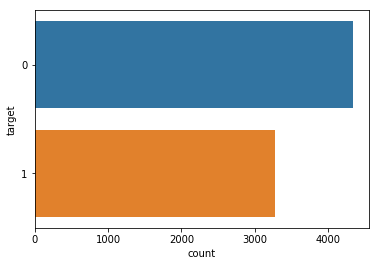

In [6]:

sns.countplot(y=train.target);

In [7]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# NA data
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

From the above evaluation we understand that Text is all non-null. Only a small percentage of tweets have no keyword. Location has much more null values.

## <a id='keyword'>2. Keywords</a>

In [10]:
# Check number of unique keywords, and whether they are the same for train and test sets
print (train.keyword.nunique(), test.keyword.nunique())
print (set(train.keyword.unique()) - set(test.keyword.unique()))

221 221
set()


Train and test have the same set of keywords

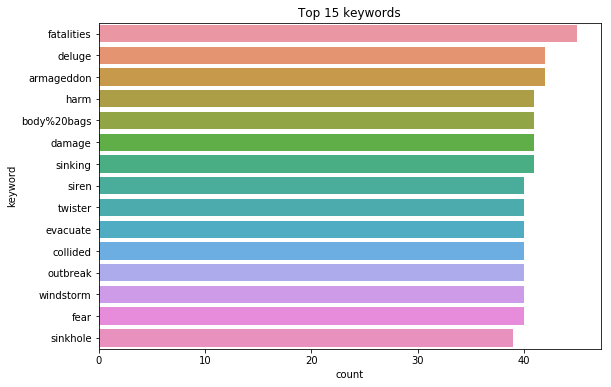

In [11]:
# Most common keywords
plt.figure(figsize=(9,6))
sns.countplot(y=train.keyword, order = train.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()
# train.keyword.value_counts().head(10)

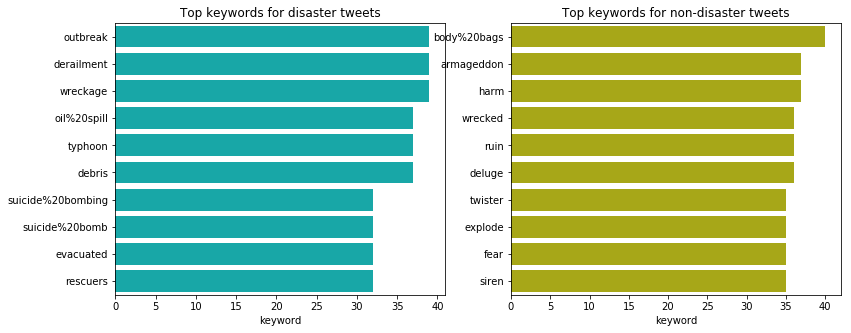

In [12]:
kw_d = train[train.target==1].keyword.value_counts().head(10)
kw_nd = train[train.target==0].keyword.value_counts().head(10)

plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(kw_d, kw_d.index, color='c')
plt.title('Top keywords for disaster tweets')
plt.subplot(122)
sns.barplot(kw_nd, kw_nd.index, color='y')
plt.title('Top keywords for non-disaster tweets')
plt.show()

There is no common top 10 keywords between disaster and non-disaster tweets.

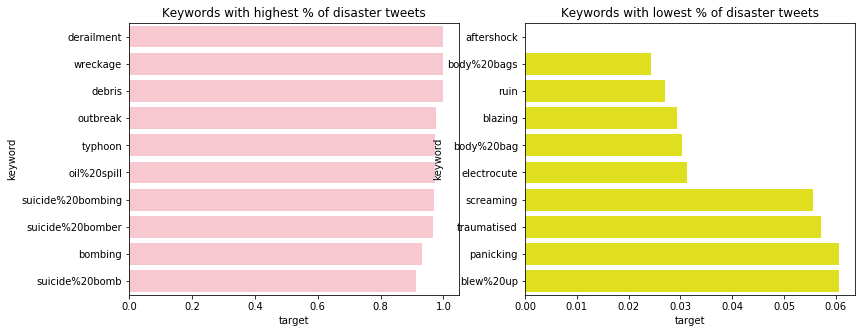

In [13]:
top_d = train.groupby('keyword').mean()['target'].sort_values(ascending=False).head(10)
top_nd = train.groupby('keyword').mean()['target'].sort_values().head(10)

plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(top_d, top_d.index, color='pink')
plt.title('Keywords with highest % of disaster tweets')
plt.subplot(122)
sns.barplot(top_nd, top_nd.index, color='yellow')
plt.title('Keywords with lowest % of disaster tweets')
plt.show()

## <a id='location'>3. Locations</a>

In [14]:
# Check number of unique keywords and locations
print (train.location.nunique(), test.location.nunique())

3341 1602


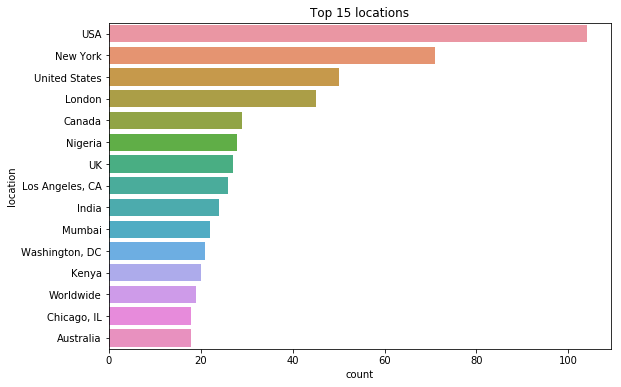

In [15]:
# Most common locations
plt.figure(figsize=(9,6))
sns.countplot(y=train.location, order = train.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations')
plt.show()

As location is free text, the data is not clean, you can see both 'USA' and 'United States' in top locations. We than have a look at % of disaster tweets for common locations.

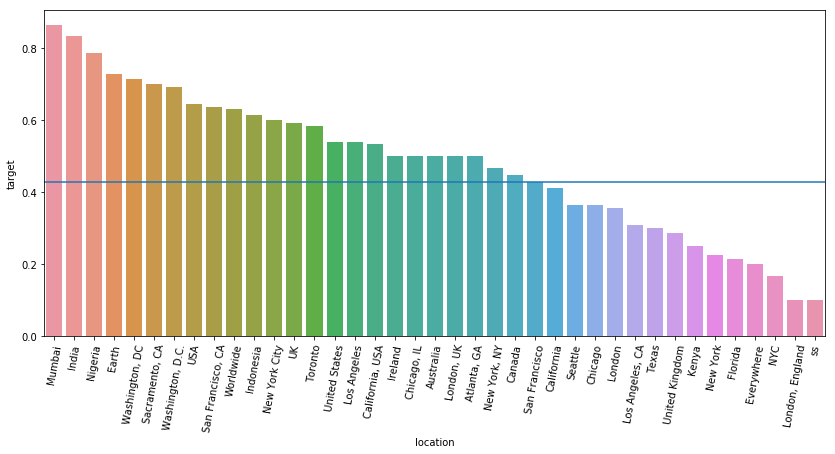

In [16]:
raw_loc = train.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = train[train.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(train.target))
plt.xticks(rotation=80)
plt.show()

The top 3 locations with highest % of disaster tweets are **Mumbai, Inida, and Nigeria**. As the location data is not clean, we see some interesting cases, such as **'London, UK' saw a higher-than-average % of disaster tweets, but 'London' is below average**. We try to clean up the location and see if there is any difference:

# Data Preprocessing Part

In [17]:
# Fill NA values
for col in ['keyword','location']:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

def clean_loc(x):
    if x == 'None':
        return 'None'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'
    elif x in top_loc:
        return x
    else: return 'Others'
    
train['location_clean'] = train['location'].apply(lambda x: clean_loc(str(x)))
test['location_clean'] = test['location'].apply(lambda x: clean_loc(str(x)))

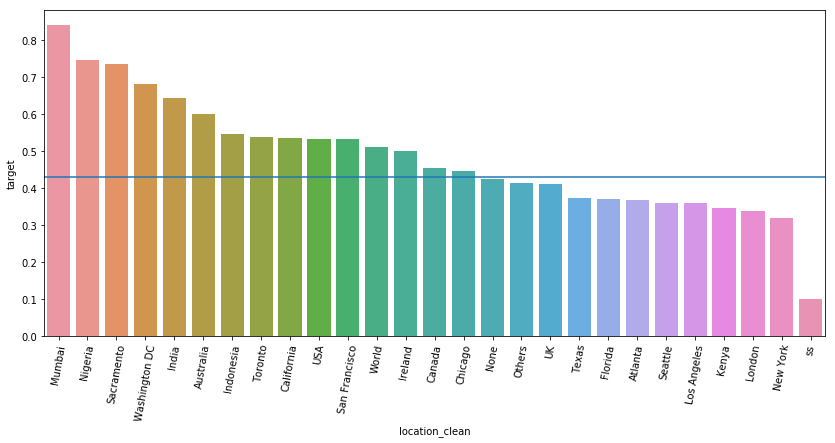

In [18]:
top_l2 = train.groupby('location_clean').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l2.index, y=top_l2)
plt.axhline(np.mean(train.target))
plt.xticks(rotation=80)
plt.show()

Mumbai and Nigeria are still on the top. Other than the strange 'ss', London and New York made the bottom of % of disaster tweets.

In [19]:
leak = pd.read_csv("../input/disasters-on-social-media/socialmedia-disaster-tweets-DFE.csv", encoding='latin_1')
leak['target'] = (leak['choose_one']=='Relevant').astype(int)
leak['id'] = leak.index
leak = leak[['id', 'target','text']]
merged_df = pd.merge(test, leak, on='id')
sub1 = merged_df[['id', 'target']]
sub1.to_csv('submit_1.csv', index=False)

# Cleaning the Data

## <a id='text'>5. Clean up Text Column</a>

Here we clean up the text column by:
- Making a 'clean' text column, removing links and unnecessary white spaces
- Creating separate columns containing lists of hashtags, mentions, and links

In [20]:
import re

test_str = train.loc[417, 'text']

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

print("Original text: " + test_str)
print("Cleaned text: " + clean_text(test_str))

Original text: Arson suspect linked to 30 fires caught in Northern California http://t.co/mmGsyAHDzb
Cleaned text: Arson suspect linked to 30 fires caught in Northern California


In [21]:
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    # df['hashtags'].fillna(value='no', inplace=True)
    # df['mentions'].fillna(value='no', inplace=True)
    
    return df
    
train = process_text(train)
test = process_text(test)

## <a id='stat'>6. Create statistics from texts</a>

In [22]:
from wordcloud import STOPWORDS

def create_stat(df):
    # Tweet length
    df['text_len'] = df['text_clean'].apply(len)
    # Word count
    df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split()))
    # Stopword count
    df['stop_word_count'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # Punctuation count
    df['punctuation_count'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Count of hashtags (#)
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    # Count of mentions (@)
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Count of links
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    # Count of uppercase letters
    df['caps_count'] = df['text_clean'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Ratio of uppercase letters
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    return df

train = create_stat(train)
test = create_stat(test)

print(train.shape, test.shape)

(7613, 19) (3263, 18)


In [23]:
train.corr()['target'].drop('target').sort_values()

stop_word_count     -0.111250
mention_count       -0.049654
caps_ratio          -0.014970
punctuation_count   -0.012535
word_count           0.017081
link_count           0.020244
caps_count           0.027808
hashtag_count        0.032853
id                   0.060781
text_len             0.096435
Name: target, dtype: float64

All of the statistics have very low correlation with the target variable

## <a id='gram'>7. Most frequent words and bigrams</a>

What are the most common unigrams (single word) and bigrams (two-word sequence)?

In [24]:
from nltk import FreqDist, word_tokenize

# Make a set of stop words
stopwords = set(STOPWORDS)
# more_stopwords = {'https', 'amp'}
# stopwords = stopwords.union(more_stopwords)

# WordCloud

In [25]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
 
wc = WordCloud().generate(stopwords)
 
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

TypeError: expected string or bytes-like object

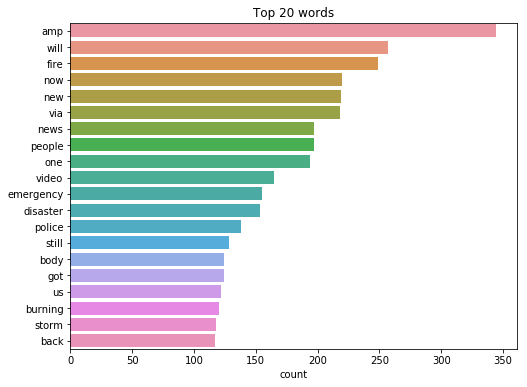

In [26]:
# Unigrams
word_freq = FreqDist(w for w in word_tokenize(' '.join(train['text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top20w['count'], top20w.index)
plt.title('Top 20 words')
plt.show()

We try to distinguish disaster and non-disaster tweets:

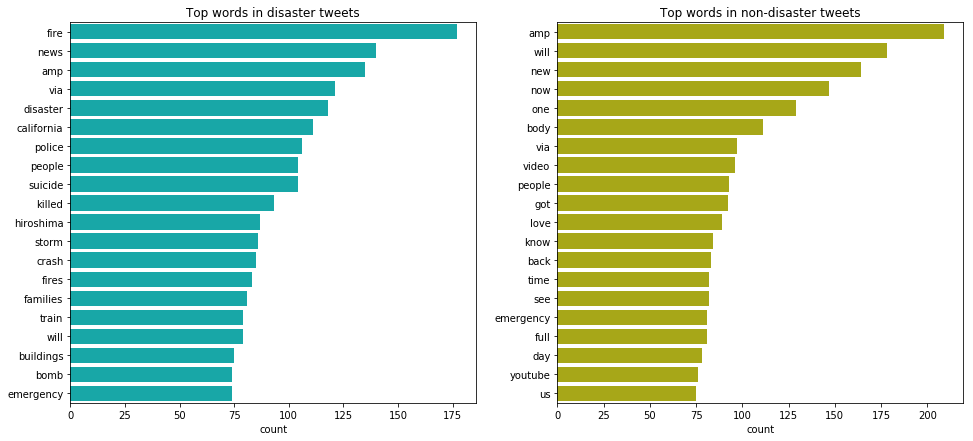

In [27]:
plt.figure(figsize=(16,7))
plt.subplot(121)
freq_d = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_d = pd.DataFrame.from_dict(freq_d, orient='index', columns=['count'])
top20_d = df_d.sort_values('count',ascending=False).head(20)
sns.barplot(top20_d['count'], top20_d.index, color='c')
plt.title('Top words in disaster tweets')
plt.subplot(122)
freq_nd = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_nd = pd.DataFrame.from_dict(freq_nd, orient='index', columns=['count'])
top20_nd = df_nd.sort_values('count',ascending=False).head(20)
sns.barplot(top20_nd['count'], top20_nd.index, color='y')
plt.title('Top words in non-disaster tweets')
plt.show()

Findings:
- Top two words in disaster tweets: 'fire' and 'news', don't make the top 20 on unreal disaster tweets.
- Words are more specific for real disaster tweets (e.g. 'califonia', 'hiroshima', 'fire', 'police', 'suicide', 'bomb').

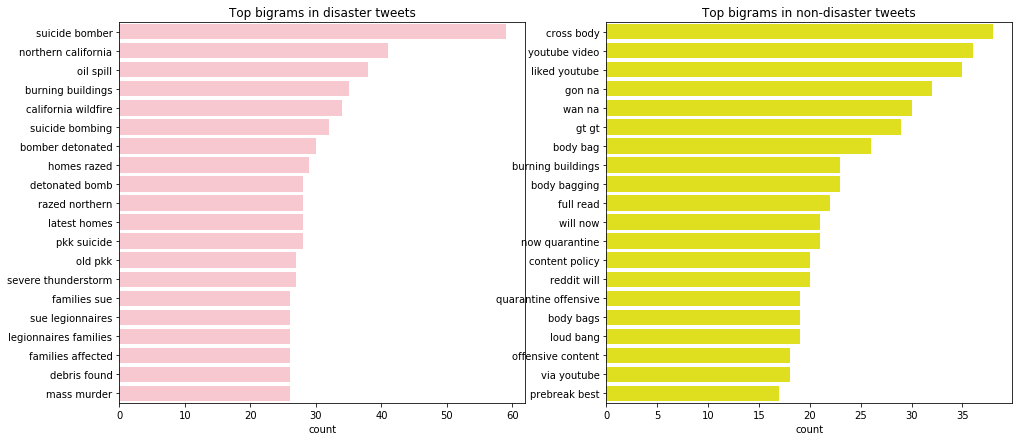

In [28]:
# Bigrams

from nltk import bigrams

plt.figure(figsize=(16,7))
plt.subplot(121)
bigram_d = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
d_fq = FreqDist(bg for bg in bigram_d)
bgdf_d = pd.DataFrame.from_dict(d_fq, orient='index', columns=['count'])
bgdf_d.index = bgdf_d.index.map(lambda x: ' '.join(x))
bgdf_d = bgdf_d.sort_values('count',ascending=False)
sns.barplot(bgdf_d.head(20)['count'], bgdf_d.index[:20], color='pink')
plt.title('Top bigrams in disaster tweets')
plt.subplot(122)
bigram_nd = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
nd_fq = FreqDist(bg for bg in bigram_nd)
bgdf_nd = pd.DataFrame.from_dict(nd_fq, orient='index', columns=['count'])
bgdf_nd.index = bgdf_nd.index.map(lambda x: ' '.join(x))
bgdf_nd = bgdf_nd.sort_values('count',ascending=False)
sns.barplot(bgdf_nd.head(20)['count'], bgdf_nd.index[:20], color='yellow')
plt.title('Top bigrams in non-disaster tweets')
plt.show()

Findings:
- Most top bigrams in disaster tweets show certain kinds of catestrophe (e.g. suicide bomber, oil spill, california wildfire); for non-disaster tweets, only 'burning buildings' as top bigram look like a disaster;
- Top bigrams in disaster tweets have a more casual tone;
- 'youtube' appears in three of the twenty bigrams for non-disaster tweets; none in disaster tweets

# Feature Engineering

## <a id='encode'>8. Encoding and Vectorizers</a>

As part of feature generation, we will:
- Apply target encoding to keyword and location (cleaned)
- Count Vectorize cleaned text, links, hashtags and mentions columns

In [29]:
import category_encoders as ce

# Target encoding
features = ['keyword', 'location_clean']
encoder = ce.TargetEncoder(cols=features)
encoder.fit(train[features],train['target'])

train = train.join(encoder.transform(train[features]).add_suffix('_target'))
test = test.join(encoder.transform(test[features]).add_suffix('_target'))

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer

# Links
vec_links = CountVectorizer(min_df = 5, analyzer = 'word', token_pattern = r'https?://\S+') # Only include those >=5 occurrences
link_vec = vec_links.fit_transform(train['links'])
link_vec_test = vec_links.transform(test['links'])
X_train_link = pd.DataFrame(link_vec.toarray(), columns=vec_links.get_feature_names())
X_test_link = pd.DataFrame(link_vec_test.toarray(), columns=vec_links.get_feature_names())

# Mentions
vec_men = CountVectorizer(min_df = 5)
men_vec = vec_men.fit_transform(train['mentions'])
men_vec_test = vec_men.transform(test['mentions'])
X_train_men = pd.DataFrame(men_vec.toarray(), columns=vec_men.get_feature_names())
X_test_men = pd.DataFrame(men_vec_test.toarray(), columns=vec_men.get_feature_names())

# Hashtags
vec_hash = CountVectorizer(min_df = 5)
hash_vec = vec_hash.fit_transform(train['hashtags'])
hash_vec_test = vec_hash.transform(test['hashtags'])
X_train_hash = pd.DataFrame(hash_vec.toarray(), columns=vec_hash.get_feature_names())
X_test_hash = pd.DataFrame(hash_vec_test.toarray(), columns=vec_hash.get_feature_names())
print (X_train_link.shape, X_train_men.shape, X_train_hash.shape)

(7613, 6) (7613, 18) (7613, 107)


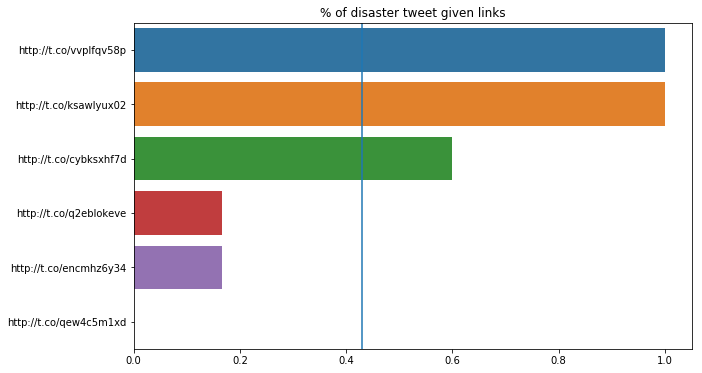

In [31]:
_ = (X_train_link.transpose().dot(train['target']) / X_train_link.sum(axis=0)).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=_, y=_.index)
plt.axvline(np.mean(train.target))
plt.title('% of disaster tweet given links')
plt.show()

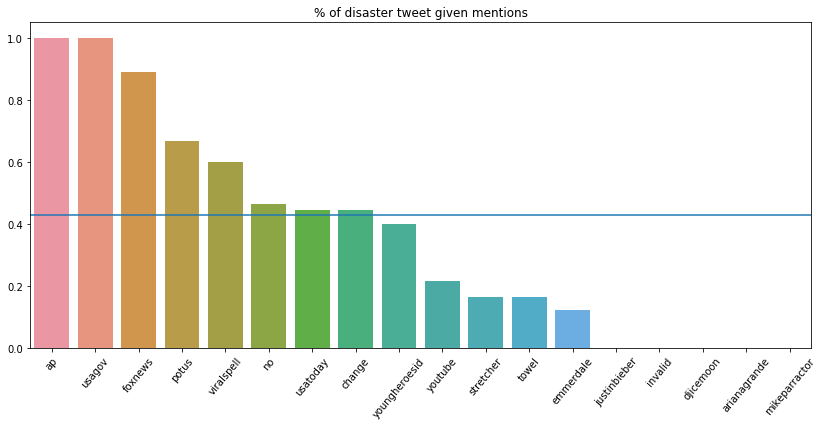

In [32]:
_ = (X_train_men.transpose().dot(train['target']) / X_train_men.sum(axis=0)).sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=_.index, y=_)
plt.axhline(np.mean(train.target))
plt.title('% of disaster tweet given mentions')
plt.xticks(rotation = 50)
plt.show()

In [33]:
hash_rank = (X_train_hash.transpose().dot(train['target']) / X_train_hash.sum(axis=0)).sort_values(ascending=False)
print('Hashtags with which 100% of Tweets are disasters: ')
print(list(hash_rank[hash_rank==1].index))
print('Total: ' + str(len(hash_rank[hash_rank==1])))
print('Hashtags with which 0% of Tweets are disasters: ')
print(list(hash_rank[hash_rank==0].index))
print('Total: ' + str(len(hash_rank[hash_rank==0])))

Hashtags with which 100% of Tweets are disasters: 
['yyc', 'japan', 'science', 'rohingya', 'okwx', 'newyork', 'myanmar', 'mumbai', 'wx', 'libya', 'india', 'socialnews', 'hiroshima', 'hailstorm', 'earthquake', 'disaster', 'breaking', 'bestnaijamade', 'antioch', 'africa', 'sittwe', 'mh370', 'abstorm', 'worldnews', 'wildfire', 'wildfires']
Total: 26
Hashtags with which 0% of Tweets are disasters: 
['np', 'summerfate', 'job', 'jobs', 'animalrescue', 'kindle', 'fashion', 'bb17', 'dnb', 'ices', 'beyhive', 'edm', 'technology', 'dubstep', 'trapmusic', 'military', 'dance', 'soundcloud']
Total: 18


# TD IDF Count

In [34]:
# Tf-idf for text
from sklearn.feature_extraction.text import TfidfVectorizer

vec_text = TfidfVectorizer(min_df = 10, ngram_range = (1,2), stop_words='english') 
# Only include >=10 occurrences
# Have unigrams and bigrams
text_vec = vec_text.fit_transform(train['text_clean'])
text_vec_test = vec_text.transform(test['text_clean'])
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())
print (X_train_text.shape)

(7613, 1691)


In [35]:
# Joining the dataframes together

train = train.join(X_train_link, rsuffix='_link')
train = train.join(X_train_men, rsuffix='_mention')
train = train.join(X_train_hash, rsuffix='_hashtag')
train = train.join(X_train_text, rsuffix='_text')
test = test.join(X_test_link, rsuffix='_link')
test = test.join(X_test_men, rsuffix='_mention')
test = test.join(X_test_hash, rsuffix='_hashtag')
test = test.join(X_test_text, rsuffix='_text')
print (train.shape, test.shape)

(7613, 1843) (3263, 1842)


# Regression Technique

### <a id='simple'>9. Logistic Regression</a>

We try the simplest model with logistic regression, based on all features we created above. Before we fit a model, we first transform the features into the same scale with minimum 0 and maximum 1. We do this in the form of pipeline.

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

features_to_drop = ['id', 'keyword','location','text','location_clean','text_clean', 'hashtags', 'mentions','links']
scaler = MinMaxScaler()

X_train = train.drop(columns = features_to_drop + ['target'])
X_test = test.drop(columns = features_to_drop)
y_train = train.target

lr = LogisticRegression(solver='liblinear', random_state=777) # Other solvers have failure to converge problem

pipeline = Pipeline([('scale',scaler), ('lr', lr),])

pipeline.fit(X_train, y_train)
y_test = pipeline.predict(X_test)

submit = sub_sample.copy()
submit.target = y_test
submit.to_csv('submit_lr.csv',index=False)

In [37]:
print ('Training accuracy: %.4f' % pipeline.score(X_train, y_train))

Training accuracy: 0.8539


# F1 SCORE

In [38]:
# F-1 score
from sklearn.metrics import f1_score

print ('Training f-1 score: %.4f' % f1_score(y_train, pipeline.predict(X_train)))

Training f-1 score: 0.8195


# Confusion matrix

In [39]:

from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_train, pipeline.predict(X_train)))

,0,1
0,3976,366
1,746,2525


This forms the basis of evaluating and modifying our models in the next section.

# Hypertuning

## <a id='improve'>10. Evaluate and Improve Our Model</a>

Several things will be done:
- Cross validation with shuffle split
- Feature selections
- Grid search for hyperparameters
- Identify errors

Reference: [scoring parameters](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

In [40]:
# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
cv_score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
print('Cross validation F-1 score: %.3f' %np.mean(cv_score))

Cross validation F-1 score: 0.753


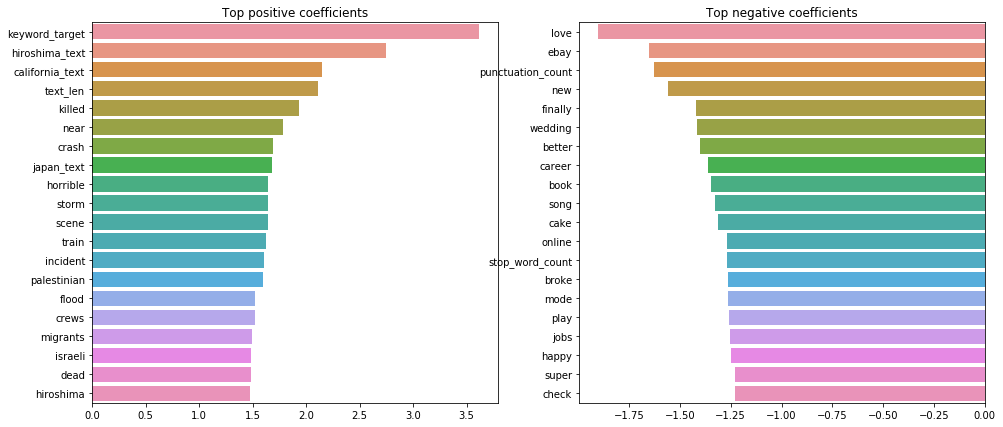

In [41]:
# Top features
plt.figure(figsize=(16,7))
s1 = pd.Series(np.transpose(lr.coef_[0]), index=X_train.columns).sort_values(ascending=False)[:20]
s2 = pd.Series(np.transpose(lr.coef_[0]), index=X_train.columns).sort_values()[:20]
plt.subplot(121)
sns.barplot(y=s1.index, x=s1)
plt.title('Top positive coefficients')
plt.subplot(122)
sns.barplot(y=s2.index, x=s2)
plt.title('Top negative coefficients')
plt.show()

Findings:
- 'keyword_target' is the top positive coefficient, meaning the keyword column made a good feature
- hiroshima both as text and hashtag made the top 20 positive coefficients
- Punctuation count and stop word count are among top 20 negative coefficients
- None of the bigrams made the top features

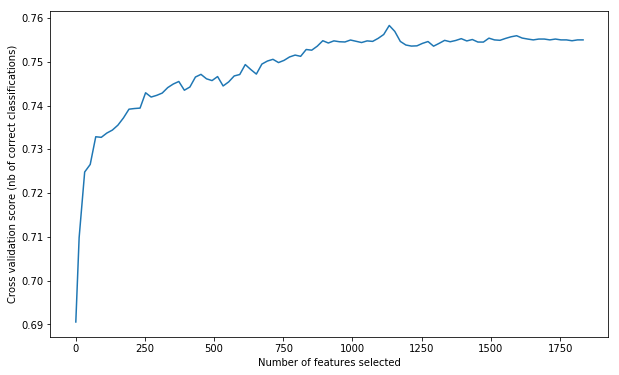

In [42]:
# Feature selection
from sklearn.feature_selection import RFECV

steps = 20
n_features = len(X_train.columns)
X_range = np.arange(n_features - (int(n_features/steps)) * steps, n_features+1, steps)

rfecv = RFECV(estimator=lr, step=steps, cv=cv, scoring='f1')

pipeline2 = Pipeline([('scale',scaler), ('rfecv', rfecv)])
pipeline2.fit(X_train, y_train)
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(np.insert(X_range, 0, 1), rfecv.grid_scores_)
plt.show()

In [43]:
print ('Optimal no. of features: %d' % np.insert(X_range, 0, 1)[np.argmax(rfecv.grid_scores_)])

Optimal no. of features: 1133


We then pick up the 1133 selected features to do Grid Search CV to find optimal hyperparameters

In [44]:
selected_features = X_train.columns[rfecv.ranking_ == 1]
X_train2 = X_train[selected_features]
X_test2 = X_test[selected_features]

In [45]:
# lr2 = LogisticRegression(solver='liblinear', random_state=37)
pipeline.fit(X_train2, y_train)
cv2 = ShuffleSplit(n_splits=5, test_size=0.2, random_state=456)
cv_score2 = cross_val_score(pipeline, X_train2, y_train, cv=cv2, scoring='f1')
print('Cross validation F-1 score: %.3f' %np.mean(cv_score2))

Cross validation F-1 score: 0.778


A little improvement from the earlier model

In [46]:
from sklearn.model_selection import GridSearchCV

grid={"C":np.logspace(-2,2,5), "penalty":["l1","l2"]}
lr_cv = GridSearchCV(LogisticRegression(solver='liblinear', random_state=20), grid, cv=cv2, scoring = 'f1')

pipeline_grid = Pipeline([('scale',scaler), ('gridsearch', lr_cv),])

pipeline_grid.fit(X_train2, y_train)

print("Best parameter: ", lr_cv.best_params_)
print("F-1 score: %.3f" %lr_cv.best_score_)

Best parameter:  {'C': 1.0, 'penalty': 'l2'}
F-1 score: 0.777


Default hyperparameters gave the best score.

# Output data for Submission

In [47]:
# Submit fine-tuned model

y_test2 = pipeline_grid.predict(X_test2)
submit2 = sub_sample.copy()
submit2.target = y_test2
submit2.to_csv('submit_lr2.csv',index=False)

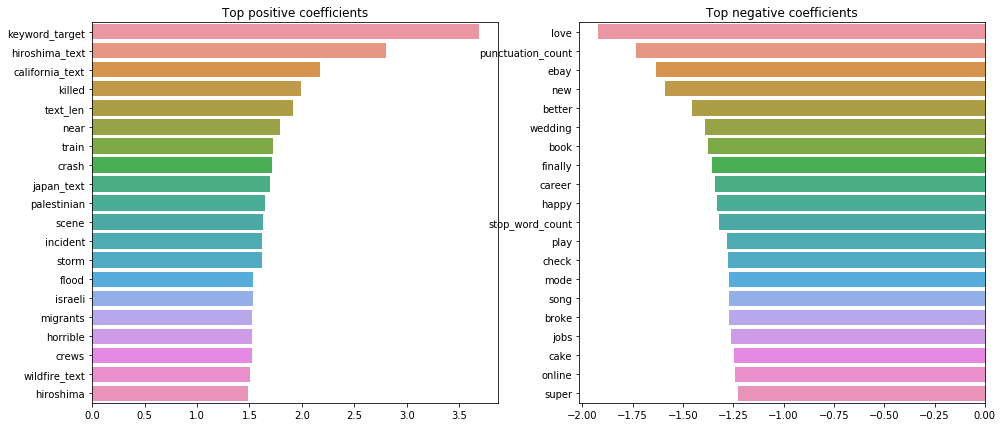

In [48]:
# Top features with fine-tuned model
plt.figure(figsize=(16,7))
s1 = pd.Series(np.transpose(lr.coef_[0]), index=X_train2.columns).sort_values(ascending=False)[:20]
s2 = pd.Series(np.transpose(lr.coef_[0]), index=X_train2.columns).sort_values()[:20]
plt.subplot(121)
sns.barplot(y=s1.index, x=s1)
plt.title('Top positive coefficients')
plt.subplot(122)
sns.barplot(y=s2.index, x=s2)
plt.title('Top negative coefficients')
plt.show()

Next, we inspect the tweets that predicted probability differs the most from target outcome

In [49]:
# Error analysis
y_hat = pipeline_grid.predict_proba(X_train2)[:,1]
checker = train.loc[:,['text','keyword','location','target']]
checker['pred_prob'] = y_hat
checker['error'] = np.abs(checker['target'] - checker['pred_prob'])

# Top 50 mispredicted tweets
error50 = checker.sort_values('error', ascending=False).head(50)
error50 = error50.rename_axis('id').reset_index()
error50.target.value_counts()

1    46
0     4
Name: target, dtype: int64

Among the top 50 mispredicted tweets, only 4 are false positive

In [50]:
pd.options.display.max_colwidth = 200

error50.loc[0:10,['text','target','pred_prob']]

,text,target,pred_prob
0,all that panicking made me tired ;__; i want to sleep in my bed,1,0.036210
1,@OllyMursAus I do feel sorry for him! He is not a piece of meat! He is a nice guy... People don't need to rush him and screams in his face!,1,0.041255
2,@BenKin97 @Mili_5499 remember when u were up like 4-0 and blew it in one game? U probs don't because it was before the kings won the cup,1,0.044444
3,The Opposite of Love is Fear HereÛªs Why\nhttp://t.co/r5bXZzhXkm,1,0.049278
4,I liked a @YouTube video from @itsjustinstuart http://t.co/oDV3RqS8JU GUN RANGE MAYHEM!,1,0.050012
5,Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!,1,0.052895
6,Do you feel like you are sinking in low self-image? Take the quiz: http://t.co/bJoJVM0pjX http://t.co/wHOc7LHb5F,1,0.055010
7,I can't drown my demons they know how to swim,1,0.056132
8,Just came back from camping and returned with a new song which gets recorded tomorrow. Can't wait! #Desolation #TheConspiracyTheory #NewEP,1,0.056308
9,How long O Lord (Study 3)\n The sixth seal opens the events of Revelation 12. The political upheaval in the Roman... http://t.co/GW0CXoOJyV,1,0.058423


Reading the tweet texts, it is quite strange that they are labelled as disaster tweets indeed.

That's it for now. Stay tuned for more analysis!